# Hierarchical Bayesian Modelling in Real life

This notebook was created for PyData NYC 2018.  

### Import all necessary libraries

In [1]:
%matplotlib inline
import sys
sys.path.append('/Users/benjaminbatorsky/Documents/services_returns/src/')

In [2]:
import pymc3 as pm
import theano.tensor as tt
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from sklearn import metrics
import seaborn as sns
from theano import shared

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


In [3]:
def run_model(model, m_name, trace_num=5000, tune=1000):
    with model:
        trace = pm.sample(trace_num, tune=tune)[tune:]
    pm.plots.traceplot(trace)
    print("\nDIC: {}".format(pm.stats.dic(model=model, trace=trace)))
    return(trace)

## Background

## Campaign spend data

This data comes from X digital marketing campaigns since 2016.  They are distributed across Y businesses.  Besides business ID, we have a set of variables that will be important to the model.  We also code each of them as an id, which will be useful later in our modelling.:

billed_amount : The amount billed for the campaign.  This is based on real data, but is not itself real.  Privacy issues and all that.

log_billed_amount : The log of billed_amount.  This is to enforce a more normal distribution on our outcome variable.  It's not necessary, but it's easier for the analysis.  Typically, spend amounts are log-normally distributed.  There's a fair number of high spenders, and a large number of low spenders.

product : The products we'll be focused on. They are as follows:
    - Display = Display advertising, like you might see on a website
    - SEM = Search Engine Marketing, dealing with "sponsored" search results in Google and Bing
    - SEO = Search Engine Optimization, general name for services that aim to increase "organic" traffic, or traffic outside of paid services
    - Social = Advertising on social networks, specifically Facebook and Instagram
    - Email = Direct email advertising, like you might get in your inbox.
    
size : Size of the company.  We have grouped this into four categories: Less than 50 employees, between 50 and 100,  more than 100 and "unavailable".  Unavailable just means we were unable to capture this information.

region : The region of the company headquarters.  There are four: Northeast, South, Midwest and West.


It is important to think on what *exactly* are we predicting the value of what.  We are trying to get to the value of "spend" as a measure of something.  We have available data on all closed opportunities under services, and a series of variables already created.  Two key questions pop out as important

#### Do we want to include the size of a first opportunity on predicting follow-on opportunities? 
This is initially not clear as it leads to two different models with different applications.  A model that requires the size of the initial opportunity to be included can only think about firms *after* they have made it into the pipeline of Propel.  A model that does not include the size of the initial opportunity can be much broader, but it is less accurate.  

To address this, two models would need to eventually be created.  For now, let's call this the *Initial Spend* model, where we look at the first month of spend


In [7]:
campaign_data = pd.read_csv('spend_data_distribute.csv')

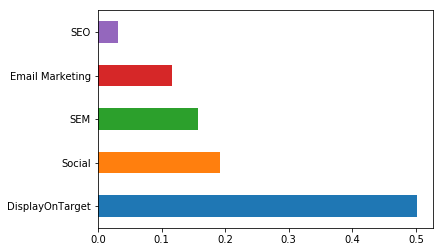

In [8]:
campaign_data['product'].value_counts(normalize=True).plot(kind='barh')

In [13]:
# drop those without industry
campaign_data = campaign_data[campaign_data.industry!='unavailable']
campaign_data.shape

(7523, 11)

In [15]:
# for pooled: need dummy variables
dummy_dict = {}
for c in ['product', 'size', 'region', 'industry']:
    dummy_dict[c] = pd.get_dummies(campaign_data[c]).iloc[:,1:]

In [17]:
dummy_dict[c].shape

(7523, 21)

In [19]:
model_dict = {}
# non-hierarchical / pooled
with pm.Model() as model:
    product_betas = pm.Normal('product_betas', mu=0., sd=1.0, 
                              shape=campaign_data['product'].nunique()-1)
    size_betas = pm.Normal('size_betas', mu=0., sd=1.0, 
                           shape=campaign_data['size'].nunique()-1)
    region_betas = pm.Normal('region_betas', mu=0., sd=1.0,
                             shape=campaign_data['region'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=0., sd=1.0,
                               shape=campaign_data['industry'].nunique()-1)
    intercept = pm.Normal('Intercept', 0., sd=1.0)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = intercept+pm.math.dot(product_betas, dummy_dict['product'].values.T)+\
        pm.math.dot(size_betas, dummy_dict['size'].values.T)+\
        pm.math.dot(region_betas, dummy_dict['region'].values.T)+\
        pm.math.dot(industry_betas, dummy_dict['industry'].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['pooled'] = model

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, Intercept, industry_betas, region_betas, size_betas, product_betas]
Sampling 2 chains: 100%|██████████| 8000/8000 [13:34<00:00, 11.93draws/s] 
The acceptance probability does not match the target. It is 0.910228074181, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


AttributeError: module 'pymc3.stats' has no attribute 'dic'

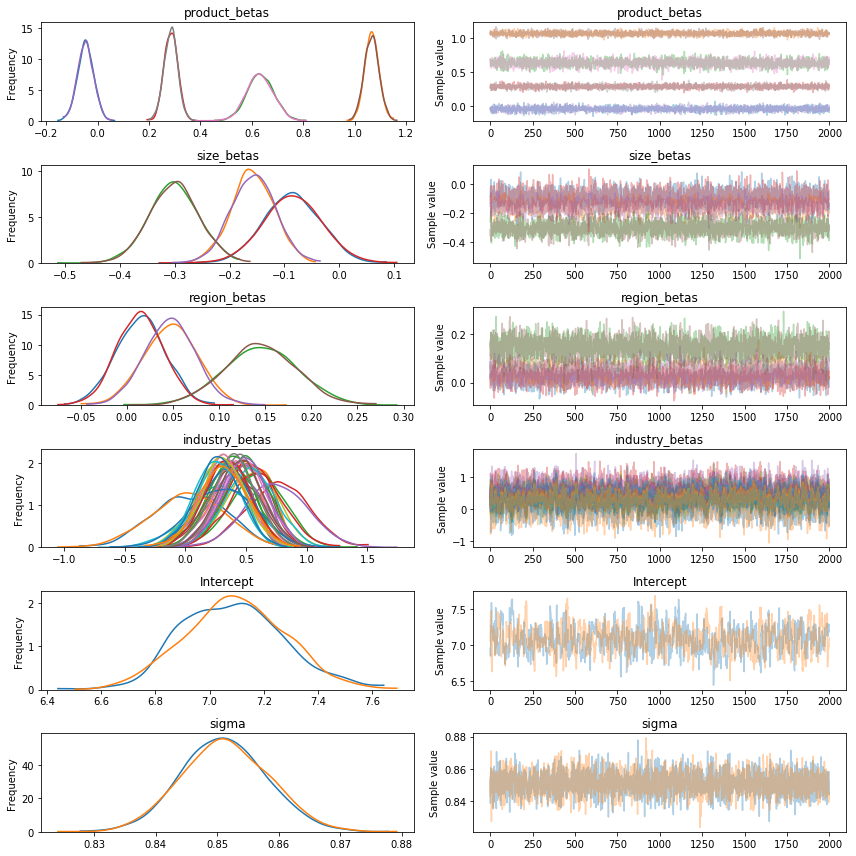

In [20]:
trace_dict = {}
trace_dict['pooled'] = run_model(model_dict['pooled'], 'pooled', trace_num=3000, tune=1000)

In [ ]:
model_dict = {}
# non-hierarchical / pooled
with pm.Model() as model:
    product_betas = pm.Normal('product_betas', mu=0., sd=1.0, 
                              shape=campaign_data['product'].nunique()-1)
    size_betas = pm.Normal('size_betas', mu=0., sd=1.0, 
                           shape=campaign_data['size'].nunique()-1)
    region_betas = pm.Normal('region_betas', mu=0., sd=1.0,
                             shape=campaign_data['region'].nunique()-1)
    industry_betas = pm.Normal('industry_betas', mu=0., sd=1.0,
                               shape=campaign_data['industry'].nunique()-1)
    intercept = pm.Normal('Intercept', 0., sd=1.0)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = intercept+pm.math.dot(product_betas, dummy_dict['product'])[campaign_data['product_idx']]+\
        size_betas[campaign_data['size_idx']]+\
        region_betas[campaign_data['region_idx']]+\
        industry_betas[campaign_data['industry_idx']]
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=campaign_data['log_billed_amount'])
model_dict['pooled'] = model

This finance data is at the bill level, so we need to aggregate at the opportunity level.

This means the sum of all amounts, even if that bill is scheduled.

We also need the minimum date of the opportunity, which we will treat as the "signing date".  This could also be close date, but I feel the first bill is when it's really finalized.  If this "signing date" is within 30 days of the first observation for a customer, then we will consider it part of their initial contract;

acccount's initial contract = All opportunities whose first billing date was within 30 days of the account's first billing date

## The Model

The model tries to predict amount spent based on a series of firm characteristics in the Services space.  

The model is a simple model. It assumes the (logged) outcome is normally distributed for some mean $\mu_i$ and standard deviation $\sigma_i$

$$y_i \sim\ N(\mu_i , \sigma_i)$$

The mean itself is simply estimated through a series of observables $X_i$ changed by parameters $\beta_i$.  
$$ \mu_i = \beta_i  X_i $$

The priors are as follows

$$ \beta \sim\ N(0,1) $$
$$ \sigma_i \sim\ HalfCauchy(0,1) $$


In [ ]:
model_dict = {}
model_feats = list(set(features) - set(['northeast']))

In [ ]:
# sample for ease of sampling
X_sample = X.sample(frac=.3)

In [ ]:
# non-hierarchical / pooled
model_feats = list(set(features) - set(['northeast']))
# create shared variable
predictors = shared(X_sample[model_feats].values.T)
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0., sd=1.0, shape=len(model_feats))
    intercept = pm.Normal('Intercept', 0., sd=1.0)
    sigma = pm.HalfCauchy('sigma', beta=1)
    
    mu = intercept+pm.math.dot(betas, predictors)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, 
                        observed=X_sample['log_amount'])
model_dict['pooled'] = model

In [ ]:
# hierarchical with channel fixed effects 
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0., sd=1.0, shape=len(model_feats))
    ch_betas = pm.Normal('ch_betas', 0, sd=1.0, shape=len(products))
    sigma = pm.HalfCauchy('sigma', beta=1)
     
    mu = ch_betas[X_sample['product_idx'].values]+pm.math.dot(betas, X_sample[model_feats].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, observed=X_sample['log_amount'])
model_dict['product_fe'] = model

In [ ]:
# hierarchical with region fixed effects 
region_model_feats = list(set(features) - set(f_list['region']))
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0., sd=1.0, shape=len(region_model_feats))
    region_alphas = pm.Normal('reg_betas', 0, sd=1.0, shape=len(f_list['region']))
    sigma = pm.HalfCauchy('sigma', beta=1)
     
    mu = reg_betas[X_sample['region_idx'].values]+pm.math.dot(betas, X_sample[region_model_feats].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, observed=X_sample['log_amount'])
model_dict['region_fe'] = model

In [ ]:
# hierarchical with channel+region fixed effects 
with pm.Model() as model:
    betas = pm.Normal('betas', mu=0., sd=1.0, shape=len(region_model_feats))
    ch_betas = pm.Normal('ch_betas', 0, sd=1.0, shape=len(products))
    reg_betas = pm.Normal('reg_betas', 0, sd=1.0, shape=len(f_list['region']))
    sigma = pm.HalfCauchy('sigma', beta=1)
     
    mu = ch_betas[X_sample['product_idx'].values]+\
    reg_betas[X_sample['region_idx'].values]+\
    pm.math.dot(betas, X_sample[region_model_feats].values.T)
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, observed=X_sample['log_amount'])
model_dict['region_product_fe'] = model

In [ ]:
# hierachical with region : channel
with pm.Model() as model:
    ch_betas = pm.Normal('ch_betas', 0, sd=1.0, shape=len(products))
    reg_betas = pm.Normal('reg_betas', 0, sd=1.0, shape=len(f_list['region']))
    sigma = pm.HalfCauchy('sigma', beta=1)
     
    mu = ch_betas[X_sample['product_idx'].values]+\
    reg_betas[X_sample['region_idx'].values]
    mu_pred = pm.Normal('y', mu=mu, sd=sigma, observed=X_sample['log_amount'])
model_dict['region_X_product'] = model

In [ ]:
tt.config.gcc.cxxflags = "-Wno-c++11-narrowing"

In [ ]:
trace_dict = {}
for m in models:
    print(m)
    trace_dict[m] = run_model(model_dict[m], m, trace_num=5000, tune=2000)

In [ ]:
pm.traceplot(trace_dict['ch_reg_fe'])

In [ ]:
ppc_dict = {}
fig, ax = plt.subplots()
channel = 'SEM'

label_dict = {'base':'pooled', 'ch_fe': 'product', 'ch_reg_fe': 'product+region'}

for m in ['base', 'ch_fe', 'ch_reg_fe']:
    print(m)
    ppc_dict[m] = pm.sample_ppc(trace_dict[m], model=model_dict[m], samples=1000)['y']
    if m == 'ch_separate':
        pred_y = ppc_dict[m][0]
    else:
        pred_y = ppc_dict[m][0][(X_sample.product_family==channel).values]
    if m in label_dict:
        sns.kdeplot(pred_y, ax=ax, label=label_dict[m])
    else:
        sns.kdeplot(pred_y, ax=ax, label=m)
    actual_y = X_sample[X_sample.product_family==channel]['log_amount']
    mae = metrics.mean_absolute_error(actual_y, pred_y)
    print mae/actual_y.std()
    print metrics.r2_score(actual_y, pred_y)
sns.kdeplot(actual_y, ax=ax, label='actual')
ax.set_xlabel('log spend')
ax.set_title('Predicted ranges vs actual')

In [ ]:
waics_dict = {}
for k in trace_dict:
    print(k)
    waics_dict[k] = pm.waic(trace_dict[k], model_dict[k])
    print(waics_dict[k])
    

In [ ]:
ppc_dict = {}
fig, ax = plt.subplots()

for m in model_dict:
    print m
    ppc_dict[m] = pm.sample_ppc(trace_dict[m], model=model_dict[m], samples=1000)['y']
    pred_y = ppc_dict[m][10]
    sns.kdeplot(pred_y, ax=ax, label=m)
    actual_y = X_sample['log_amount']
    mae = metrics.mean_absolute_error(actual_y, pred_y)
    print mae/actual_y.std()
    print metrics.r2_score(actual_y, pred_y)
sns.kdeplot(actual_y, ax=ax, label='actual')

In [ ]:
# Changing values here will also change values in the model
predictors.set_value(X[model_feats].iloc[:100].values.T)